# COVID-19 Project
### Data Engineering Capstone Project

#### Project Summary
The purpose of the project is to combine what we've learned throughout the program.
I took several COVID-19 datasets and joined them to make a useful source of 
information regarding COVID-19 spread globally. I focus on:
- cases
- deaths
- vaccinations: how many doses were given, and how many people are considered vaccinated and what stage

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

### Step 1: Scope the Project and Gather Data

#### Scope 
Explain what you plan to do in the project in more detail. What data do you use? What is your end solution look like? What tools did you use? etc>

#### Describe and Gather Data 
Describe the data sets you're using. Where did it come from? What type of information is included? 

In [180]:
import pandas as pd

def explore_df(df):
    print(df.info())
    df.describe()
    print(df.head(3))

def check_time_series(df_check, date_col, group_by):
    # check that the time series column doesn't have missing gaps

    min_date = df_check[date_col].min()
    max_date = df_check[date_col].max()
    date_range = set(
        d.strftime('%Y-%m-%d') for d in
        pd.date_range(min_date, max_date, freq='D'))
    total_days = len(date_range)
    
    def _check_group(df_group):
        group_value = df_group.iloc[0][group_by]
        missing_dates = date_range - set(df_group[date_col].unique())

        if missing_dates:
            print(f'found missing time series for {group_value} '
                  f'- {len(missing_dates)} days missing (~{round(100*len(missing_dates)/total_days)}%)')
                
    df_check.groupby(group_by).apply(_check_group)

def describe_nulls(df, thr=0.05):
    df_nulls = df.isnull().mean().reset_index()
    return df_nulls[df_nulls[0] > thr]

# describe duplicates
def get_duplicates(df, columns):
    return df[df.duplicated(subset=columns)]

def describe_duplicates(df, columns):
    df_dups = get_duplicates(df, columns)
    print('Duplicate ratio:', round(100*len(df_dups)/len(df)), '%')
    return df_dups

df_activity = pd.read_csv('./data/activity.csv')
df_population = pd.read_csv('./data/population.csv')
df_vaccinations_global = pd.read_csv('./data/vaccinations_global.csv')
df_vaccinations_usa_doeses = pd.read_csv('./data/vaccinations_usa_doeses.csv')
df_vaccinations_usa_people = pd.read_csv('./data/vaccinations_usa_people.csv')


/usr/local/Caskroom/miniconda/base/envs/personal/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Explore COVID19 Activity table

* Total of 2157792 rows in the Activity Table.
* This is time series from 2020-01-29 to 2021-09-19 for 222 countries world wide. 
* This data comes from two sources:
    - New York Times
    - JHU CSSE Global Timeseries 

In [181]:
explore_df(df_activity)

print('Unique countries count:', len(df_activity.COUNTRY_SHORT_NAME.unique()))
print('Minimum date:', df_activity.REPORT_DATE.min())
print('Maxium date:', df_activity.REPORT_DATE.max())
print('Data sources:', df_activity.DATA_SOURCE_NAME.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2157792 entries, 0 to 2157791
Data columns (total 13 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   PEOPLE_POSITIVE_CASES_COUNT      int64  
 1   COUNTY_NAME                      object 
 2   PROVINCE_STATE_NAME              object 
 3   REPORT_DATE                      object 
 4   CONTINENT_NAME                   object 
 5   DATA_SOURCE_NAME                 object 
 6   PEOPLE_DEATH_NEW_COUNT           int64  
 7   COUNTY_FIPS_NUMBER               float64
 8   COUNTRY_ALPHA_3_CODE             object 
 9   COUNTRY_SHORT_NAME               object 
 10  COUNTRY_ALPHA_2_CODE             object 
 11  PEOPLE_POSITIVE_NEW_CASES_COUNT  int64  
 12  PEOPLE_DEATH_COUNT               int64  
dtypes: float64(1), int64(4), object(8)
memory usage: 214.0+ MB
None
   PEOPLE_POSITIVE_CASES_COUNT COUNTY_NAME PROVINCE_STATE_NAME REPORT_DATE  \
0                         1263       Perry        

In [182]:
explore_df(df_population)

print('Unique countries count:', len(df_population.COUNTRY_SHORT_NAME.unique()))
print('Data sources:', df_population.DATA_SOURCE_NAME.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3483 entries, 0 to 3482
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   COUNTRY_SHORT_NAME           3483 non-null   object 
 1   COUNTRY_ALPHA_3_CODE         3483 non-null   object 
 2   COUNTRY_ALPHA_2_CODE         3482 non-null   object 
 3   PROVINCE_STATE_NAME          3272 non-null   object 
 4   COUNTY_NAME                  3218 non-null   object 
 5   COUNTY_FIPS_NUMBER           3218 non-null   float64
 6   GEO_LATITUDE                 3483 non-null   float64
 7   GEO_LONGITUDE                3483 non-null   float64
 8   GEO_REGION_POPULATION_COUNT  3483 non-null   int64  
 9   DATA_SOURCE_NAME             3483 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 272.2+ KB
None
  COUNTRY_SHORT_NAME COUNTRY_ALPHA_3_CODE COUNTRY_ALPHA_2_CODE  \
0        Afghanistan                  AFG                   AF

In [183]:
explore_df(df_vaccinations_global)

print('Unique countries count:', len(df_vaccinations_global.Country_Region.unique()))
print('Minimum date:', df_vaccinations_global.Date.min())
print('Maxium date:', df_vaccinations_global.Date.max())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74658 entries, 0 to 74657
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Country_Region               74658 non-null  object 
 1   Date                         74658 non-null  object 
 2   Doses_admin                  74658 non-null  int64  
 3   People_partially_vaccinated  35165 non-null  float64
 4   People_fully_vaccinated      35165 non-null  float64
 5   Report_Date_String           74658 non-null  object 
 6   UID                          74328 non-null  float64
 7   Province_State               38999 non-null  object 
dtypes: float64(3), int64(1), object(4)
memory usage: 4.6+ MB
None
  Country_Region        Date  Doses_admin  People_partially_vaccinated  \
0    Afghanistan  2021-02-22            0                          0.0   
1    Afghanistan  2021-02-23            0                          0.0   
2    Afghanistan  2021-

In [184]:
explore_df(df_vaccinations_usa_doeses)

print('Minimum date:', df_vaccinations_usa_doeses.Date.min())
print('Maxium date:', df_vaccinations_usa_doeses.Date.max())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92092 entries, 0 to 92091
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Province_State   92092 non-null  object 
 1   Date             92092 non-null  object 
 2   Vaccine_Type     92092 non-null  object 
 3   FIPS             83920 non-null  float64
 4   Country_Region   92092 non-null  object 
 5   Lat              83920 non-null  float64
 6   Long_            83920 non-null  float64
 7   Doses_alloc      15089 non-null  float64
 8   Doses_shipped    71169 non-null  float64
 9   Doses_admin      74964 non-null  float64
 10  Stage_One_Doses  43711 non-null  float64
 11  Stage_Two_Doses  49121 non-null  float64
 12  Combined_Key     92092 non-null  object 
dtypes: float64(8), object(5)
memory usage: 9.1+ MB
None
  Province_State        Date Vaccine_Type  FIPS Country_Region      Lat  \
0        Alabama  2020-12-10          All   1.0             US  32.31

In [185]:
explore_df(df_vaccinations_usa_people)

print('Minimum date:', df_vaccinations_usa_people.Date.min())
print('Maxium date:', df_vaccinations_usa_people.Date.max())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17446 entries, 0 to 17445
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   FIPS                         16016 non-null  float64
 1   Province_State               17446 non-null  object 
 2   Country_Region               17446 non-null  object 
 3   Date                         17446 non-null  object 
 4   Lat                          16016 non-null  float64
 5   Long_                        16016 non-null  float64
 6   Combined_Key                 17446 non-null  object 
 7   People_Fully_Vaccinated      15087 non-null  float64
 8   People_Partially_Vaccinated  14431 non-null  float64
dtypes: float64(5), object(4)
memory usage: 1.2+ MB
None
   FIPS Province_State Country_Region        Date      Lat    Long_  \
0   1.0        Alabama             US  2020-12-10  32.3182 -86.9023   
1   1.0        Alabama             US  2020-12-11  32.3

### Step 2: Explore and Assess the Data

# Check COVID-19 Activity table
No missing time series data per reported countries

In [186]:
# check for date gaps in the data
check_time_series(df_activity, 'REPORT_DATE', 'COUNTRY_SHORT_NAME')

In [187]:
# check for null values spread
describe_nulls(df_activity)

,index,0
1,COUNTY_NAME,0.077487
2,PROVINCE_STATE_NAME,0.061426
7,COUNTY_FIPS_NUMBER,0.093266


In [188]:
describe_duplicates(df_activity, ('COUNTRY_SHORT_NAME', 'REPORT_DATE', 'PROVINCE_STATE_NAME', 'COUNTY_NAME'))

Duplicate ratio: 0 %


,PEOPLE_POSITIVE_CASES_COUNT,COUNTY_NAME,PROVINCE_STATE_NAME,REPORT_DATE,CONTINENT_NAME,DATA_SOURCE_NAME,PEOPLE_DEATH_NEW_COUNT,COUNTY_FIPS_NUMBER,COUNTRY_ALPHA_3_CODE,COUNTRY_SHORT_NAME,COUNTRY_ALPHA_2_CODE,PEOPLE_POSITIVE_NEW_CASES_COUNT,PEOPLE_DEATH_COUNT


# Check Population table


In [189]:
# check for null values spread
describe_nulls(df_population)

,index,0
3,PROVINCE_STATE_NAME,0.060580
4,COUNTY_NAME,0.076084
5,COUNTY_FIPS_NUMBER,0.076084


In [190]:
describe_duplicates(df_population, ('COUNTRY_SHORT_NAME', 'PROVINCE_STATE_NAME', 'COUNTY_NAME'))

Duplicate ratio: 0 %


,COUNTRY_SHORT_NAME,COUNTRY_ALPHA_3_CODE,COUNTRY_ALPHA_2_CODE,PROVINCE_STATE_NAME,COUNTY_NAME,COUNTY_FIPS_NUMBER,GEO_LATITUDE,GEO_LONGITUDE,GEO_REGION_POPULATION_COUNT,DATA_SOURCE_NAME


In [191]:
df_population[df_population['COUNTRY_SHORT_NAME']=='United States'].GEO_REGION_POPULATION_COUNT.sum()

323251434

# Check COVID-19 Vaccinations tables - global and usa
There are missing timeseries information

In [192]:
check_time_series(df_vaccinations_global, 'Date', 'Country_Region')

found missing time series for Afghanistan - 88 days missing (~31%)
found missing time series for Albania - 29 days missing (~10%)
found missing time series for Algeria - 126 days missing (~45%)
found missing time series for Andorra - 49 days missing (~18%)
found missing time series for Angola - 94 days missing (~34%)
found missing time series for Antigua and Barbuda - 82 days missing (~29%)
found missing time series for Argentina - 16 days missing (~6%)
found missing time series for Armenia - 147 days missing (~52%)
found missing time series for Australia - 63 days missing (~22%)
found missing time series for Austria - 14 days missing (~5%)
found missing time series for Azerbaijan - 34 days missing (~12%)
found missing time series for Bahamas - 102 days missing (~36%)
found missing time series for Bahrain - 9 days missing (~3%)
found missing time series for Bangladesh - 44 days missing (~16%)
found missing time series for Barbados - 65 days missing (~23%)
found missing time series for 

In [193]:
describe_nulls(df_vaccinations_global)

,index,0
3,People_partially_vaccinated,0.528986
4,People_fully_vaccinated,0.528986
7,Province_State,0.477631


In [194]:
describe_duplicates(df_vaccinations_global, ('Date', 'Country_Region'))

Duplicate ratio: 52 %


,Country_Region,Date,Doses_admin,People_partially_vaccinated,People_fully_vaccinated,Report_Date_String,UID,Province_State
1470,Bangladesh,2021-05-28,427518,NaN,NaN,2021-05-29,5001.0,Barisal
1471,Bangladesh,2021-05-29,427518,NaN,NaN,2021-05-30,5001.0,Barisal
1472,Bangladesh,2021-05-30,427518,NaN,NaN,2021-05-31,5001.0,Barisal
1473,Bangladesh,2021-05-31,427518,NaN,NaN,2021-06-01,5001.0,Barisal
1474,Bangladesh,2021-05-28,2001467,NaN,NaN,2021-05-29,5002.0,Chittagong
...,...,...,...,...,...,...,...,...
74646,United Kingdom,2021-09-19,2840,NaN,NaN,2021-09-20,500.0,Montserrat
74647,United Kingdom,2021-09-19,2505605,NaN,NaN,2021-09-20,82602.0,Northern Ireland
74648,United Kingdom,2021-09-19,7892,NaN,NaN,2021-09-20,654.0,"Saint Helena, Ascension and Tristan da Cunha"
74649,United Kingdom,2021-09-19,7962028,NaN,NaN,2021-09-20,82603.0,Scotland


The duplicates ratio is high, let's investigate more

In [195]:
df_vaccinations_global[
    (df_vaccinations_global.Country_Region=='Bangladesh') & 
    (df_vaccinations_global.Date == '2021-05-28')]

,Country_Region,Date,Doses_admin,People_partially_vaccinated,People_fully_vaccinated,Report_Date_String,UID,Province_State
1466,Bangladesh,2021-05-28,9901717,5823245.0,4115773.0,2021-05-29,50.0,NaN
1470,Bangladesh,2021-05-28,427518,NaN,NaN,2021-05-29,5001.0,Barisal
1474,Bangladesh,2021-05-28,2001467,NaN,NaN,2021-05-29,5002.0,Chittagong
1478,Bangladesh,2021-05-28,3221588,NaN,NaN,2021-05-29,5003.0,Dhaka
1482,Bangladesh,2021-05-28,1217243,NaN,NaN,2021-05-29,5004.0,Khulna
1486,Bangladesh,2021-05-28,472413,NaN,NaN,2021-05-29,5005.0,Mymensingh
1490,Bangladesh,2021-05-28,1070678,NaN,NaN,2021-05-29,5006.0,Rajshahi
1494,Bangladesh,2021-05-28,974035,NaN,NaN,2021-05-29,5007.0,Rangpur
1498,Bangladesh,2021-05-28,516775,NaN,NaN,2021-05-29,5008.0,Sylhet
1502,Bangladesh,2021-05-28,0,NaN,NaN,2021-05-29,5009.0,Unassigned


For `Bangaladesh`, clearly I missed column `Province_State` as primary key here. 
- `Province_State` must be taken into account
- need to drop when Province_State is "Unassigned"

In [196]:
describe_duplicates(df_vaccinations_global, ('Date', 'Country_Region', 'Province_State'))

Duplicate ratio: 0 %


,Country_Region,Date,Doses_admin,People_partially_vaccinated,People_fully_vaccinated,Report_Date_String,UID,Province_State


Cool this is the key we need to look at
Date, Country_Region and Province_State

Another observation from this table is that values for People_partially_vaccinated and People_fully_vaccinated is relevant only at the 'Global Country' row where Province_State is NaN. This is very important to us when we fill the appropriate Fact table for people vaccinated. 

In [197]:
check_time_series(df_vaccinations_usa_doeses, 'Date', 'Province_State')

found missing time series for Bureau of Prisons - 173 days missing (~60%)
found missing time series for Federal Bureau of Prisons - 81 days missing (~28%)
found missing time series for Federated States of Micronesia - 175 days missing (~61%)
found missing time series for Marshall Islands - 175 days missing (~61%)
found missing time series for Republic of Palau - 175 days missing (~61%)


In [198]:
describe_nulls(df_vaccinations_usa_doeses)

,index,0
3,FIPS,0.088737
5,Lat,0.088737
6,Long_,0.088737
7,Doses_alloc,0.836153
8,Doses_shipped,0.227197
9,Doses_admin,0.185988
10,Stage_One_Doses,0.525355
11,Stage_Two_Doses,0.466609


In [199]:
describe_duplicates(df_vaccinations_usa_doeses, ('Date', 'Country_Region', 'Province_State'))

Duplicate ratio: 81 %


,Province_State,Date,Vaccine_Type,FIPS,Country_Region,Lat,Long_,Doses_alloc,Doses_shipped,Doses_admin,Stage_One_Doses,Stage_Two_Doses,Combined_Key
1,Alabama,2020-12-10,Moderna,1.0,US,32.3182,-86.9023,NaN,NaN,NaN,NaN,NaN,"Alabama, US"
2,Alabama,2020-12-10,Pfizer,1.0,US,32.3182,-86.9023,NaN,NaN,NaN,NaN,NaN,"Alabama, US"
4,Alabama,2020-12-11,Moderna,1.0,US,32.3182,-86.9023,NaN,NaN,NaN,NaN,NaN,"Alabama, US"
5,Alabama,2020-12-11,Pfizer,1.0,US,32.3182,-86.9023,NaN,NaN,NaN,NaN,NaN,"Alabama, US"
7,Alabama,2020-12-12,Moderna,1.0,US,32.3182,-86.9023,NaN,NaN,NaN,NaN,NaN,"Alabama, US"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92087,Wyoming,2021-09-21,Janssen,56.0,US,42.7560,-107.3025,NaN,35600.0,23131.0,21511.0,NaN,"Wyoming, US"
92088,Wyoming,2021-09-21,Pfizer,56.0,US,42.7560,-107.3025,NaN,314175.0,254783.0,NaN,113188.0,"Wyoming, US"
92089,Wyoming,2021-09-21,Moderna,56.0,US,42.7560,-107.3025,NaN,294860.0,231650.0,NaN,101550.0,"Wyoming, US"
92090,Wyoming,2021-09-21,All,56.0,US,42.7560,-107.3025,NaN,644635.0,509934.0,276188.0,214886.0,"Wyoming, US"


There is a very high rate of duplicates. By looking at the data I can tell the cause is that there are separate values for each Vaccination Type (Moderna, Pfizer, Janssen etc)

In [200]:
df_vaccinations_usa_doeses[
    (df_vaccinations_usa_doeses.Country_Region=='US') & 
    (df_vaccinations_usa_doeses.Province_State == 'Wyoming') &
    (df_vaccinations_usa_doeses.Date == '2021-09-19')]

,Province_State,Date,Vaccine_Type,FIPS,Country_Region,Lat,Long_,Doses_alloc,Doses_shipped,Doses_admin,Stage_One_Doses,Stage_Two_Doses,Combined_Key
92074,Wyoming,2021-09-19,Unknown,56.0,US,42.756,-107.3025,NaN,0.0,370.0,NaN,NaN,"Wyoming, US"
92075,Wyoming,2021-09-19,Janssen,56.0,US,42.756,-107.3025,NaN,35600.0,23034.0,21417.0,NaN,"Wyoming, US"
92076,Wyoming,2021-09-19,Pfizer,56.0,US,42.756,-107.3025,NaN,314175.0,253444.0,NaN,112520.0,"Wyoming, US"
92077,Wyoming,2021-09-19,Moderna,56.0,US,42.756,-107.3025,NaN,294860.0,230822.0,NaN,101149.0,"Wyoming, US"
92078,Wyoming,2021-09-19,All,56.0,US,42.756,-107.3025,NaN,644635.0,507670.0,275154.0,213815.0,"Wyoming, US"
92079,Wyoming,2021-09-19,Unassigned,56.0,US,42.756,-107.3025,NaN,0.0,0.0,253737.0,146.0,"Wyoming, US"


So just to make sure, let's check duplicate by adding also the Vaccination Type and see what happens

In [201]:
describe_duplicates(df_vaccinations_usa_doeses, ('Date', 'Country_Region', 'Province_State', 'Vaccine_Type'))

Duplicate ratio: 0 %


,Province_State,Date,Vaccine_Type,FIPS,Country_Region,Lat,Long_,Doses_alloc,Doses_shipped,Doses_admin,Stage_One_Doses,Stage_Two_Doses,Combined_Key


Very good, no duplicates. We can assume our aggregations will be flawless after cleanups.

In [202]:
check_time_series(df_vaccinations_usa_people, 'Date', 'Province_State')

In [203]:
describe_nulls(df_vaccinations_usa_people)

,index,0
0,FIPS,0.081967
4,Lat,0.081967
5,Long_,0.081967
7,People_Fully_Vaccinated,0.135217
8,People_Partially_Vaccinated,0.172819


In [204]:
describe_duplicates(df_vaccinations_usa_people, ('Date', 'Country_Region', 'Province_State'))

Duplicate ratio: 0 %


,FIPS,Province_State,Country_Region,Date,Lat,Long_,Combined_Key,People_Fully_Vaccinated,People_Partially_Vaccinated


# Check Population table

In [205]:
describe_nulls(df_population)

,index,0
3,PROVINCE_STATE_NAME,0.060580
4,COUNTY_NAME,0.076084
5,COUNTY_FIPS_NUMBER,0.076084


# Compatibility between Data sources

The join between tables is going to be on **Country name** and **Date**

The date was checked above and is ok to use on joins.

The country name is more difficult to join on, there is a normalization 
challange of the country name.
it can be called in different ways and 
it's our mission to join the gap between the data sources.

In [206]:
# check countries on all tables, what is the overlap ratio
df_activity_countries = set(df_activity.COUNTRY_SHORT_NAME.unique())
df_population_countries = set(df_population.COUNTRY_SHORT_NAME.unique())
df_vacc_global_countries = set(df_vaccinations_global.Country_Region.unique())

# how much conutry columns overlap in join?
print(
    'Activity and Populations countries compatibility rate: ',
    round(
        len(df_activity_countries & df_population_countries) / 
            max(len(df_activity_countries), len(df_population_countries)), 2)
)

# how much conutry columns overlap in join between 'Activity' and 'Vaccinations'?
print(
    'Activity and Global Vaccinations countries compatibility rate: ',
    round(
        len(df_activity_countries & df_vacc_global_countries) / 
            max(len(df_activity_countries), len(df_vacc_global_countries)), 2)
)

print('-'*40)
print('What countries are missing:', ', '.join(
    (df_activity_countries | df_vacc_global_countries) - (df_activity_countries & df_vacc_global_countries)
))

Activity and Populations countries compatibility rate:  0.97
Activity and Global Vaccinations countries compatibility rate:  0.73
----------------------------------------
What countries are missing: Cuba, Turks and Caicos Islands, Saint Pierre and Miquelon, West Bank and Gaza, Burundi, Anguilla, Cook Islands, Burkina Faso, Congo (Kinshasa), French Polynesia, Reunion, Chad, Haiti, Yemen, Niger, New Caledonia, St Martin, Libya, Saint Barthelemy, Madagascar, Liberia, Falkland Islands (Malvinas), Bermuda, Isle of Man, Curacao, US (Aggregate), US, Eritrea, Congo (Brazzaville), Holy See, Tajikistan, Bonaire, Sint Eustatius and Saba, Comoros, Djibouti, Samoa, Sint Maarten, World, French Guiana, Lesotho, Wallis and Futuna, United States, British Virgin Islands, Greenland, Gibraltar, Timor-Leste, Somalia, Tanzania, Aruba, Central African Republic, Guinea-Bissau, Guadeloupe, Benin, Mayotte, Vanuatu, Faroe Islands, Montserrat, Summer Olympics 2020, Channel Islands, Kiribati, Cabo Verde, Martiniqu

## Country compatibility results

 - Between Activity table and Population table there is a very high rate of compatibility (as expected, the tables came from the same source and creator).

 - Between Activity table and Vaccinations table there is some mismatches (73% compatibility between countries names). Maybe can use other columns to join. In the following block let's take more columns (ISO names) to consideration and see how it imacts our join success ratio.


In [207]:
df_activity_countries = (
    set(df_activity.COUNTRY_SHORT_NAME.unique()) | 
    set(df_activity.COUNTRY_ALPHA_3_CODE.unique()) | 
    set(df_activity.COUNTRY_ALPHA_2_CODE.unique()))
df_population_countries = set(df_population.COUNTRY_SHORT_NAME.unique())
df_vacc_global_countries = set(df_vaccinations_global.Country_Region.unique())

# how much conutry columns overlap in join?
print(
    'Activity and Global Vaccinations countries compatibility rate: ',
    round(
        len(df_activity_countries & df_vacc_global_countries) / 
            len(df_vacc_global_countries), 2))

Activity and Global Vaccinations countries compatibility rate:  0.99


### So I we join with conutry name and ISO codes we should be fine (0.99 success on join)

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model


### Fact - Worldwide Covid19 Activity
all activity information

schema:
- *date*
- *continent*
- *country*
- *province*
- *death_count*
- *infected_count*
- *death_rate*
- *infected_rate*
- *population_count*
- *doeses_administraed_count*
- *vaccinated_people_count*
- *doeses_administraed_rate*
- *vaccinated_people_rate*
- *geo_latitude*
- *geo_longitude*
- *data_source_name*


### Dim - continent
- find unique continent on activity table

schema:
- *continent*
- *geo_latitude*
- *geo_longitude*

### Dim - data sources
- find unique data sources on activity table

schema:
- *data_source_name*

### Dim - countries
- join from activity table and population table
country name, iso, continent, geo position

schema:
- *continent*
- *country*
- *province*
- *geo_latitude*
- *geo_longitude*

### Dim - Vaccination types
- get from vaccinations usa table the types

schema:
- *vacc_type*

#### 3.2 Mapping Out Data Pipelines

In order to get the our final data model from the raw sources we perform the following steps:

1. create dim_continent table from 'activity' data source: use `CONTINENT_NAME`
2. create dim_data_sources table from `activity` source, on the `DATA_SOURCE_NAME` column and `population` source, on the `DATA_SOURCE_NAME` column.
3. create dim_vaccinations_types from `vaccinations_usa_doeses` source, on the `Vaccine_Type` column
4. create dim_countries table from
    - `population` source
    - `df_vaccinations_global` source
    - `df_vaccinations_usa_doeses` source
    - `df_vaccinations_usa_people` source
5. create fact table `fact_cov19_activity` from
    - `activity` source - get the infections and deaths count
    - `population` source - get population and geo location
    - `df_vaccinations_global` source - fetch doeses adminstration and people vaccinated status worldwide
    - `df_vaccinations_usa_doeses` source - fetch doeses adminstration in USA
    - `df_vaccinations_usa_people` source - fetch people vaccinated status in USA


### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

### Read dataframes

In [2]:
import findspark  
from pyspark.sql import SparkSession 
import pyspark.sql.functions as F



def create_spark_session():
    findspark.init() 
    spark = SparkSession \
        .builder \
        .appName('lab') \
        .getOrCreate()
    return spark

spark = create_spark_session()

def read_sources(spark):
    return (
        spark.read.csv('./data/activity.csv', header=True),
        spark.read.csv('./data/population.csv', header=True),
        spark.read.csv('./data/vaccinations_global.csv', header=True),
        spark.read.csv('./data/vaccinations_usa_doeses.csv', header=True),
        spark.read.csv('./data/vaccinations_usa_people.csv', header=True),
    )

df_activity, df_population, df_vacc_global, df_vacc_usa_doses, df_vacc_usa_people = read_sources(spark)

 

21/09/23 05:23:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### Create `dim_continent`

create dim_continent table from 'activity' data source: use `CONTINENT_NAME`


In [209]:

df_continent = df_activity\
    .select('COUNTRY_SHORT_NAME', 'CONTINENT_NAME')\
    .dropna()\
    .dropDuplicates()\
    .persist()\
    .join(df_population, 'COUNTRY_SHORT_NAME').groupBy(
        'CONTINENT_NAME'
).agg(
    F.mean('GEO_LATITUDE').alias('geo_latitude'),
    F.mean('GEO_LONGITUDE').alias('geo_longitude'))\
        .withColumnRenamed('CONTINENT_NAME', 'continent_name')

print(df_continent.show())
df_continent.write.parquet('./out/dim_continent', mode='overwrite')

21/09/23 04:57:17 WARN CacheManager: Asked to cache already cached data.


+--------------+-------------------+------------------+
|continent_name|       geo_latitude|     geo_longitude|
+--------------+-------------------+------------------+
|        Europe|  48.36586981132077|16.198949056603773|
|        Africa|  2.253339285714287|18.444239285714286|
|       Oceania|-22.331523529411765|115.05505882352942|
|          Asia| 28.272672000000004| 92.58368666666665|
|       America|  37.54757498476536|-91.12666703229745|
+--------------+-------------------+------------------+

None


## Draw the Continent Geo locations we infered from Activity+Populations tables

In [210]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

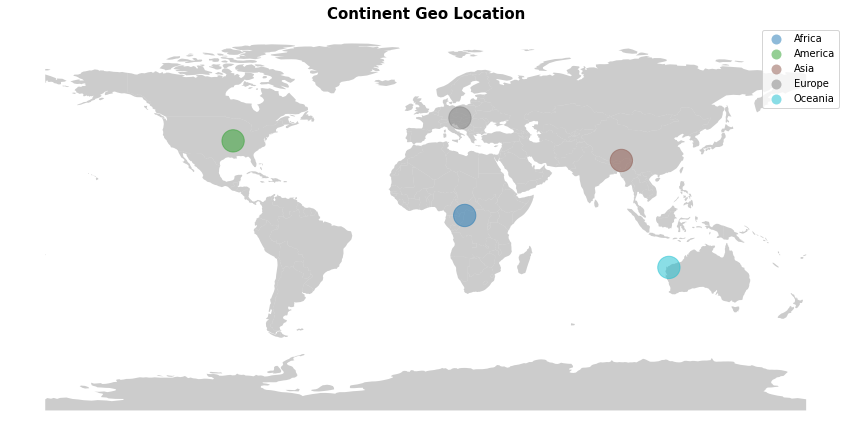

In [211]:
df = df_continent.toPandas()

# get worlf image
world = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres')
)

# zip x and y coordinates into single feature
geometry = [Point(xy) for xy in zip(df['geo_longitude'], df['geo_latitude'])]
# create GeoPandas dataframe
geo_df = gpd.GeoDataFrame(df,
 geometry = geometry)

 # create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(15,15))
ax.axis('off')
world.plot(ax=ax, alpha=0.4,color='grey')

geo_df.plot(column='continent_name',ax=ax,alpha=0.5, legend=True,markersize=500)
# add title to graph
plt.title('Continent Geo Location', fontsize=15,fontweight='bold')

# show map
plt.show()

### Create `dim_data_sources`

create dim_data_sources table from `activity` source, on the `DATA_SOURCE_NAME` column and `population` source, on the `DATA_SOURCE_NAME` column.

In [212]:

df_data_sources = df_activity\
    .select('DATA_SOURCE_NAME')\
    .dropna()\
    .dropDuplicates()\
        .union(
            df_population.select('DATA_SOURCE_NAME')\
                .dropna()\
                .dropDuplicates()
        )

print(df_data_sources.show())
df_data_sources.write.parquet('./out/dim_data_sources', mode='overwrite')

+--------------------+
|    DATA_SOURCE_NAME|
+--------------------+
|JHU CSSE Global T...|
|      New York Times|
|Census Bureau - 2...|
|United Nations - ...|
|JHU CSSE Lookup T...|
+--------------------+

None


### Create `dim_vaccinations_types`

create dim_vaccinations_types from `vaccinations_usa_doeses` source, on the `Vaccine_Type` column

In [213]:
valid_vaccination_type_condition = (
    (F.col('Vaccine_Type') !='Unknown') &
    (F.col('Vaccine_Type') !='All') &
    (F.col('Vaccine_Type') !='Unassigned')
)

df_vacc_types = df_vacc_usa_doses\
    .filter(valid_vaccination_type_condition)\
    .select('Vaccine_Type')\
    .dropna()\
    .dropDuplicates()

print(df_vacc_types.show())
df_vacc_types.write.parquet('./out/dim_vaccinations_types', mode='overwrite')

+------------+
|Vaccine_Type|
+------------+
|      Pfizer|
|     Janssen|
|     Moderna|
+------------+

None


## Create `dim_countries`

create dim_countries table from
 - `population` source

 schema:
- *continent*
- *country*
- *province*
- *geo_latitude*
- *geo_longitude*

In [3]:
df_conutries = df_activity\
    .select('COUNTRY_SHORT_NAME', 'CONTINENT_NAME')\
    .dropna()\
    .dropDuplicates()\
    .persist()\
    .join(df_population, 'COUNTRY_SHORT_NAME', 'right_outer')\
    .selectExpr(
        'CONTINENT_NAME as continent',
        'COUNTRY_SHORT_NAME as country',
        'PROVINCE_STATE_NAME as province',
        'DOUBLE(GEO_LATITUDE) as geo_latitude',
        'DOUBLE(GEO_LONGITUDE) as geo_longitude') \
    .dropDuplicates(subset=['continent', 'country', 'province'])

df_conutries.show(10)
df_conutries.write.parquet('./out/dim_countries', mode='overwrite')

+---------+----------+--------+------------+-------------+
|continent|   country|province|geo_latitude|geo_longitude|
+---------+----------+--------+------------+-------------+
|   Africa|      Chad|    null|      15.981|       18.781|
|  America|  Anguilla|    null|     18.2177|     -63.0406|
|  America|  Paraguay|    null|     -23.266|      -58.409|
|   Europe|    Russia|    null|      64.736|      104.062|
|     Asia|     Yemen|    null|      15.569|       47.793|
|   Africa|   Senegal|    null|      15.044|      -15.081|
|   Africa|Cabo Verde|    null|      15.416|       -23.36|
|   Europe|    Sweden|    null|     66.2188|         19.0|
|  America|    Guyana|    null|        5.17|      -58.939|
|     Asia|     Burma|    null|      21.841|        96.05|
+---------+----------+--------+------------+-------------+
only showing top 10 rows



21/09/23 05:24:10 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
21/09/23 05:24:10 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
21/09/23 05:24:10 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
21/09/23 05:24:10 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 69.09% for 11 writers
21/09/23 05:24:10 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 63.33% for 12 writers
21/09/23 05:24:10 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 69.09% for 11 writers
21/09/23 05:24:10 WARN MemoryManager: Total allocation exceeds 95.

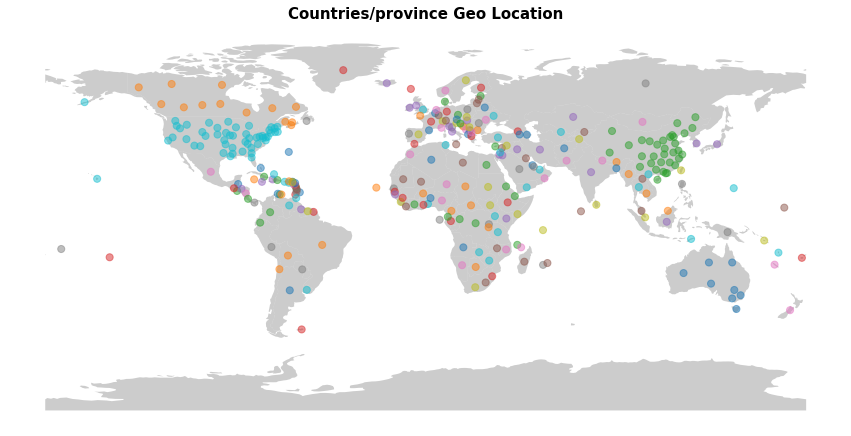

In [215]:
df = df_conutries.dropna(subset=['geo_longitude', 'geo_latitude']).toPandas()

# get worlf image
world = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres')
)

# zip x and y coordinates into single feature
geometry = [Point(xy) for xy in zip(df['geo_longitude'], df['geo_latitude'])]
# create GeoPandas dataframe
geo_df = gpd.GeoDataFrame(df,
 geometry = geometry)

 # create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(15,15))
ax.axis('off')
world.plot(ax=ax, alpha=0.4,color='grey')

geo_df.plot(column='country',ax=ax,alpha=0.5, legend=False, markersize=50)
# add title to graph
plt.title('Countries/province Geo Location', fontsize=15,fontweight='bold')

# show map
plt.show()

## Create `fact_cov19_activity`

create fact table `fact_cov19_activity` from
- `activity` source - get the infections and deaths count
- `population` source - get population and geo location
- `df_vaccinations_global` source - fetch doeses adminstration and people vaccinated status worldwide
- `df_vaccinations_usa_doeses` source - fetch doeses adminstration in USA
- `df_vaccinations_usa_people` source - fetch people vaccinated status in USA

In [216]:

df_population_clean = df_population.selectExpr(
    'COUNTY_NAME',
    'PROVINCE_STATE_NAME',
    'COUNTRY_ALPHA_3_CODE',
    'COUNTRY_SHORT_NAME',
    'COUNTRY_ALPHA_2_CODE',
    'DOUBLE(GEO_LATITUDE) as GEO_LATITUDE',
    'DOUBLE(GEO_LONGITUDE) as GEO_LONGITUDE',
    'INT(GEO_REGION_POPULATION_COUNT) as GEO_REGION_POPULATION_COUNT'
).fillna(0)


df_poplucation_clean_by_province = df_population_clean.groupBy(
        'COUNTRY_SHORT_NAME', 
        'PROVINCE_STATE_NAME',
        'COUNTRY_ALPHA_3_CODE',
        'COUNTRY_ALPHA_2_CODE').agg(
            F.sum('GEO_REGION_POPULATION_COUNT').alias('GEO_REGION_POPULATION_COUNT'),
            F.avg('GEO_LATITUDE').alias('GEO_LATITUDE'),
            F.avg('GEO_LONGITUDE').alias('GEO_LONGITUDE'),
        )


# get all doses administered data

df_cov19_fact_vacc_doses_1 = df_vacc_global.selectExpr(
    'Country_Region as country',
    'Province_State as province',
    'Date as date',
    'INT(Doses_admin) as doses_admin'
).withColumn('vacc_type', F.lit('Unknown'))

df_cov19_fact_vacc_doses_2 = df_vacc_usa_doses.filter(valid_vaccination_type_condition)\
    .selectExpr(
        'Country_Region as country',
        'Province_State as province',
        'Date as date',
        'INT(Doses_admin) as doses_admin',
        'Vaccine_Type as vacc_type'
).dropna(subset=['doses_admin'])

df_cov19_fact_vacc_doses_union = df_cov19_fact_vacc_doses_1.union(df_cov19_fact_vacc_doses_2)\
    .groupBy('country', 'province', 'date').sum('doses_admin').\
    select('country', 'province', 'date', F.col('sum(doses_admin)').alias('doses_admin'))

df_cov19_fact_vacc_doses = df_cov19_fact_vacc_doses_union\
    .join(df_poplucation_clean_by_province, (
        (
            (df_cov19_fact_vacc_doses_union.country == df_poplucation_clean_by_province.COUNTRY_SHORT_NAME) |
            (df_cov19_fact_vacc_doses_union.country == df_poplucation_clean_by_province.COUNTRY_ALPHA_3_CODE) |
            (df_cov19_fact_vacc_doses_union.country == df_poplucation_clean_by_province.COUNTRY_ALPHA_2_CODE) 
        ) & (
            (df_cov19_fact_vacc_doses_union.province == df_poplucation_clean_by_province.PROVINCE_STATE_NAME) |
            (df_cov19_fact_vacc_doses_union.province.isNull() & 
             df_poplucation_clean_by_province.PROVINCE_STATE_NAME.isNull())
        )
    ), 'left_outer')

# get all vaccinated people data

df_cov19_fact_vacc_people_1 = df_vacc_global.selectExpr(
    'Country_Region as country',
    'Province_State as province',
    'Date as date',
    'INT(People_partially_vaccinated) as people_partially_vaccinated',
    'INT(People_fully_vaccinated) as people_fully_vaccinated',
)

df_cov19_fact_vacc_people_2 = df_vacc_usa_people.selectExpr(
    'Country_Region as country',
    'Province_State as province',
    'Date as date',
    'INT(People_partially_vaccinated) as people_partially_vaccinated',
    'INT(People_fully_vaccinated) as people_fully_vaccinated',
)

df_cov19_fact_vacc_people_union = df_cov19_fact_vacc_people_1.union(df_cov19_fact_vacc_people_2)
df_cov19_fact_vacc_people = df_cov19_fact_vacc_people_union\
    .join(df_poplucation_clean_by_province, (
        (
            (df_cov19_fact_vacc_people_union.country == df_poplucation_clean_by_province.COUNTRY_SHORT_NAME) |
            (df_cov19_fact_vacc_people_union.country == df_poplucation_clean_by_province.COUNTRY_ALPHA_3_CODE) |
            (df_cov19_fact_vacc_people_union.country == df_poplucation_clean_by_province.COUNTRY_ALPHA_2_CODE) 
        ) & (
            (df_cov19_fact_vacc_people_union.province == df_poplucation_clean_by_province.PROVINCE_STATE_NAME) |
            (df_cov19_fact_vacc_people_union.province.isNull() & 
             df_poplucation_clean_by_province.PROVINCE_STATE_NAME.isNull())
        )
    ), 'left_outer')

df_activity_clean = df_activity.selectExpr(
    'INT(PEOPLE_POSITIVE_CASES_COUNT) as PEOPLE_POSITIVE_CASES_COUNT',
    'COUNTY_NAME',
    'PROVINCE_STATE_NAME',
    'REPORT_DATE',
    'CONTINENT_NAME',
    'DATA_SOURCE_NAME',
    'INT(PEOPLE_DEATH_NEW_COUNT) as PEOPLE_DEATH_NEW_COUNT',
    'COUNTRY_ALPHA_3_CODE',
    'COUNTRY_SHORT_NAME',
    'COUNTRY_ALPHA_2_CODE',
    'INT(PEOPLE_POSITIVE_NEW_CASES_COUNT) as PEOPLE_POSITIVE_NEW_CASES_COUNT',
    'INT(PEOPLE_DEATH_COUNT) as PEOPLE_DEATH_COUNT'
).fillna(0)


df_cov19_fact_activity = df_activity_clean\
    .groupBy(
        'REPORT_DATE',
        'CONTINENT_NAME',
        'COUNTRY_ALPHA_3_CODE',
        'COUNTRY_ALPHA_2_CODE',
        'DATA_SOURCE_NAME',
        df_activity_clean['COUNTRY_SHORT_NAME'], 
        df_activity_clean['PROVINCE_STATE_NAME']).agg(
            F.sum('PEOPLE_POSITIVE_CASES_COUNT').alias('PEOPLE_POSITIVE_CASES_COUNT'),
            F.sum('PEOPLE_DEATH_NEW_COUNT').alias('PEOPLE_DEATH_NEW_COUNT'),
            F.sum('PEOPLE_POSITIVE_NEW_CASES_COUNT').alias('PEOPLE_POSITIVE_NEW_CASES_COUNT'),
            F.sum('PEOPLE_DEATH_COUNT').alias('PEOPLE_DEATH_COUNT'))\
    .join(df_poplucation_clean_by_province, (
        (df_activity_clean.COUNTRY_SHORT_NAME == df_poplucation_clean_by_province.COUNTRY_SHORT_NAME) &
        (
            (df_activity_clean.PROVINCE_STATE_NAME == df_poplucation_clean_by_province.PROVINCE_STATE_NAME) | 
            (df_activity_clean.PROVINCE_STATE_NAME.isNull() | 
                df_poplucation_clean_by_province.PROVINCE_STATE_NAME.isNull()))
    ), 'left_outer')\
    .join(df_cov19_fact_vacc_doses, (
            (df_cov19_fact_vacc_doses.country == df_activity_clean.COUNTRY_SHORT_NAME) |
            (df_cov19_fact_vacc_doses.country == df_activity_clean.COUNTRY_ALPHA_3_CODE) |
            (df_cov19_fact_vacc_doses.country == df_activity_clean.COUNTRY_ALPHA_2_CODE) 
        ) & (
            (df_cov19_fact_vacc_doses.province == df_activity_clean.PROVINCE_STATE_NAME) | 
            (df_cov19_fact_vacc_doses.province.isNull() & df_activity_clean.PROVINCE_STATE_NAME.isNull())
        ) & (
            df_cov19_fact_vacc_doses.date == df_activity_clean.REPORT_DATE
        ), 'outer')\
    .join(df_cov19_fact_vacc_people, (
            (df_cov19_fact_vacc_people.country == df_activity_clean.COUNTRY_SHORT_NAME) |
            (df_cov19_fact_vacc_people.country == df_activity_clean.COUNTRY_ALPHA_3_CODE) |
            (df_cov19_fact_vacc_people.country == df_activity_clean.COUNTRY_ALPHA_2_CODE) 
        ) & (
            (df_cov19_fact_vacc_people.province == df_activity_clean.PROVINCE_STATE_NAME) |
            (df_cov19_fact_vacc_people.province.isNull() & df_activity_clean.PROVINCE_STATE_NAME.isNull())
        ) & (
            df_cov19_fact_vacc_people.date == df_activity_clean.REPORT_DATE
        ), 'outer'
    )


# pick up first valid value from columns
mergeF = F.udf(lambda *args: next(
        arg for arg in args if bool(arg)
    ) if any(args) else None
)

df_cov19_fact_activity_renames = df_cov19_fact_activity.select(
    mergeF(
        df_activity_clean.REPORT_DATE, 
        df_cov19_fact_vacc_people.date, 
        df_cov19_fact_vacc_doses.date).alias('date'),
    mergeF(
        df_activity_clean.COUNTRY_SHORT_NAME,
        df_cov19_fact_vacc_people.country,
        df_cov19_fact_vacc_doses.country,
        df_cov19_fact_vacc_people.COUNTRY_SHORT_NAME,
        df_cov19_fact_vacc_doses.COUNTRY_SHORT_NAME
        ).alias('country'),
    mergeF(
        df_activity_clean.PROVINCE_STATE_NAME,
        df_cov19_fact_vacc_people.province,
        df_cov19_fact_vacc_people.PROVINCE_STATE_NAME,
        df_cov19_fact_vacc_doses.province,
        df_cov19_fact_vacc_doses.PROVINCE_STATE_NAME
    ).alias('province'),
    F.col('PEOPLE_POSITIVE_CASES_COUNT').alias('people_positives_cases_count'),
    F.col('PEOPLE_DEATH_NEW_COUNT').alias('people_death_new_count'),
    F.col('PEOPLE_POSITIVE_NEW_CASES_COUNT').alias('people_positive_new_cases_count'),
    F.col('PEOPLE_DEATH_COUNT').alias('people_death_count'),
    F.col('DATA_SOURCE_NAME').alias('data_source_name'),
    mergeF(
        df_poplucation_clean_by_province.GEO_REGION_POPULATION_COUNT,
        df_cov19_fact_vacc_people.GEO_REGION_POPULATION_COUNT,
        df_cov19_fact_vacc_doses.GEO_REGION_POPULATION_COUNT,
    ).alias('population'),
    df_cov19_fact_vacc_people.people_partially_vaccinated,
    df_cov19_fact_vacc_people.people_fully_vaccinated,
    df_cov19_fact_vacc_doses.doses_admin,
).join(
    df_conutries,
    'country',
    'left_outer'
).drop(df_conutries.province)\
.dropDuplicates(['date', 'continent', 'country', 'province']).fillna(0)

df_cov19_fact_activity_renames.printSchema()
df_cov19_fact_activity_renames.write.parquet('./out/fact_activity', mode='overwrite')


df_cov19_fact_activity_renames.head(2)


root
 |-- country: string (nullable = true)
 |-- date: string (nullable = true)
 |-- province: string (nullable = true)
 |-- people_positives_cases_count: long (nullable = true)
 |-- people_death_new_count: long (nullable = true)
 |-- people_positive_new_cases_count: long (nullable = true)
 |-- people_death_count: long (nullable = true)
 |-- data_source_name: string (nullable = true)
 |-- population: string (nullable = true)
 |-- people_partially_vaccinated: integer (nullable = true)
 |-- people_fully_vaccinated: integer (nullable = true)
 |-- doses_admin: long (nullable = true)
 |-- continent: string (nullable = true)
 |-- geo_latitude: double (nullable = false)
 |-- geo_longitude: double (nullable = false)



21/09/23 04:58:00 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
21/09/23 04:58:00 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
21/09/23 04:58:00 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
21/09/23 04:58:00 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
21/09/23 04:58:00 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


[Row(country='Chad', date='2020-01-21', province=None, people_positives_cases_count=0, people_death_new_count=0, people_positive_new_cases_count=0, people_death_count=0, data_source_name='JHU CSSE Global Timeseries', population='15946882', people_partially_vaccinated=0, people_fully_vaccinated=0, doses_admin=0, continent='Africa', geo_latitude=15.981, geo_longitude=18.781),
 Row(country='Chad', date='2020-01-22', province=None, people_positives_cases_count=0, people_death_new_count=0, people_positive_new_cases_count=0, people_death_count=0, data_source_name='JHU CSSE Global Timeseries', population='15946882', people_partially_vaccinated=0, people_fully_vaccinated=0, doses_admin=0, continent='Africa', geo_latitude=15.981, geo_longitude=18.781)]

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

## Lets get the latest report on doses administration from Missisiippii

In [217]:
df_cov19_fact_activity_renames.filter(
    (F.col('province') == 'Mississippi') & (F.col('doses_admin')>0)
    ).orderBy(F.desc(F.col('date'))).select('date', 'doses_admin').head(1)

[Row(country='US', date='2021-09-21', province='Mississippi', people_positives_cases_count=0, people_death_new_count=0, people_positive_new_cases_count=0, people_death_count=0, data_source_name=None, population=None, people_partially_vaccinated=0, people_fully_vaccinated=0, doses_admin=2722794, continent=None, geo_latitude=0.0, geo_longitude=0.0)]

## What continent has the most positive cases of population?

In [218]:
df_cov19_fact_activity_renames.where("date='2021-09-19'").groupBy('continent').agg(
    F.sum('people_positives_cases_count'),
    F.sum('population')
).withColumn('res',
    F.col('sum(people_positives_cases_count)') / F.col('sum(population)')
).orderBy(F.desc(F.col('res'))).show()

21/09/23 04:59:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+---------+---------------------------------+---------------+--------------------+
|continent|sum(people_positives_cases_count)|sum(population)|                 res|
+---------+---------------------------------+---------------+--------------------+
|  America|                         88250856|  1.006353878E9| 0.08769366117551743|
|   Europe|                         59060747|   7.65383598E8| 0.07716489764652626|
|     Asia|                         72770282|  4.513214458E9|0.016123825419155385|
|   Africa|                          8230674|  1.307475657E9|0.006295087756268643|
|  Oceania|                           203451|    4.4253674E7|0.004597380999371939|
|     null|                             1332|           null|                null|
+---------+---------------------------------+---------------+--------------------+



# The Continet with most positive cases is America.

## What continent has the most vaccination precentage of population?

In [219]:
df_cov19_fact_activity_renames.where("date='2021-09-19'").groupBy('continent').agg(
    F.sum('people_fully_vaccinated'),
    F.sum('population')
).withColumn('res',
    F.col('sum(people_fully_vaccinated)') / F.col('sum(population)')
).orderBy(F.desc(F.col('res'))).show()

+---------+----------------------------+---------------+-------------------+
|continent|sum(people_fully_vaccinated)|sum(population)|                res|
+---------+----------------------------+---------------+-------------------+
|   Europe|                   384128780|   7.65383598E8| 0.5018774651086787|
|  America|                   399726989|  1.006353878E9| 0.3972032082734221|
|     Asia|                   564053300|  4.513214458E9|0.12497817359424936|
|  Oceania|                     2024326|    4.4253674E7|0.04574368220817101|
|   Africa|                    50804099|  1.307475657E9|0.03885663088869271|
|     null|                     5946391|           null|               null|
+---------+----------------------------+---------------+-------------------+



# The Continent with most fully vaccinated people is Europe.

#### 4.3 Data dictionary 


### Fact - Worldwide Covid19 Activity
all activity information

schema:
 |-- country: string (nullable = true) - country related to information
 |-- date: string (nullable = true) - date of the information
 |-- province: string (nullable = true) - province related to information
 |-- people_positives_cases_count: long (nullable = true) - how many total positives?
 |-- people_death_new_count: long (nullable = true) - new deaths count for the date
 |-- people_positive_new_cases_count: long (nullable = true) - how many positives to the date?
 |-- people_death_count: long (nullable = true) - total death count
 |-- data_source_name: string (nullable = true) - what is the name of the source of the information
 |-- population: string (nullable = true) - what is the population in the region
 |-- people_partially_vaccinated: integer (nullable = true) - count of partlly vaccinated (total)
 |-- people_fully_vaccinated: integer (nullable = true) - count of fully vaccinated (total)
 |-- doses_admin: long (nullable = true) - count of vaccinations administration
 |-- continent: string (nullable = true) - what continent for the region
 |-- geo_latitude: double (nullable = false) - geo lat
 |-- geo_longitude: double (nullable = false) - geo long


### Dim - continent
- find unique continent on activity table

schema:
- *continent*
- *geo_latitude*
- *geo_longitude*

### Dim - data sources
- find unique data sources on activity table

schema:
- *data_source_name*

### Dim - countries
- join from activity table and population table
country name, iso, continent, geo position

schema:
- *continent*
- *country*
- *province*
- *geo_latitude*
- *geo_longitude*

### Dim - Vaccination types
- get from vaccinations usa table the types

schema:
- *vacc_type*


#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.